# 1. Introduction
## 1.1 Summary
Assuming a company sells different kinds of alcohol across regions in Russia, there was a success after running a wine promotion in Saint Petersburg. This analysis would like to suggest further promotions to maximize the profits. However, the current situation allows us to target only a few regions due to a limited budget. By generating more short-term wins, our company will eventually extend the business throughout the country.

With regards to figuring out the current situation, analyzing the micro and macro environment is required. For example, Porter’s five forces model is a common tool to understand a business' micro-environment (Chaffey, 2019, p70). To analyse the impacts of external factors, PESTLE can be used for knowing the macro environment (Brown, 2019, p29). This report will use clustering methods to select the regions with the same wine buying behavior as Saint Petersburg. It is a part of macro environment analysis that our business can earn a higher possibility to succeed by knowing external factors. Apparently, the regions where people have a similar buying trend would be potentially affected by the same wine promotion we proceeded in Saint Petersburg.

Since the budget allows us to pick only 10 regions for the next marketing campaign, this report will not only cluster the regions by historical wine sales at all times but take into account the recent sales of all alcohol. In this way, this report is able to recommend the priority of these 10 regions for the promotions. It will be beneficial for operation management as well as project management in regards to a limited budget.

## 1.2 Analytics Tool and Dataset
This analysis uses Python as the analysis tool. The given dataset contains the sales numbers of 5 kinds of alcohol, wine, beer, vodka, champagne, and brandy, in different regions from 1998 to 2016. It has 1615 rows and 7 columns.

# 2. Prepare
## 2. Analysis Plan
The analysis plan is to answer the questions.

1. What is the sales trend of wine in different regions?
2. Which regions have the same buying behavior as Saint Petersburg?
3. What are the top 10 regions with higher potential returns for the next wine promotion?

## 2.2 Method
This report will transform the dataset into two different tables. They are for two different dimensions of analysis.

1. To cluster the regions by the sales trend of wine, this table contains historical wine sales at all times.
2. The other table contains the average sales of different alcohol during the last three years.

The analysis steps will be as follows.

1. Review the data, clean it, and then transform it into 2 major tables. 
2. Identify a ideal number of clusters for K-means by using Elbow method.
3. Cluster the regions by K-means clustering.
4. Select the top 10 areas that have the highest potential profit for the promotions.
5. Get another region list by using hierarchical clustering with the recent sales of different alcohol.
6. Comparing the clustering results from two different methods.

As for identifying a suitable number of clusters, Elbow Method can help determine the proper cluster for KMean clustering based on the sum of squared distance, SSE(Flood, 2018).

# 3. Process
## 3.1 Data Cleansing and Exploratory Data Analysis
This section involves data cleansing with an exploratory data analysis. It is a preparation of the dataset for further analysis.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/alcohol-consumption-in-russia/russia_alcohol.csv


In [2]:
 #Import modules for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [3]:
data = pd.read_csv('../input/alcohol-consumption-in-russia/russia_alcohol.csv')
data_duplicate = data.copy()
data.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


In [4]:
#Review the types of columns. It shows there are 1615 rows and 7 columns.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1615 non-null   int64  
 1   region     1615 non-null   object 
 2   wine       1552 non-null   float64
 3   beer       1557 non-null   float64
 4   vodka      1554 non-null   float64
 5   champagne  1552 non-null   float64
 6   brandy     1549 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 88.4+ KB


year          0
region        0
wine         63
beer         58
vodka        61
champagne    63
brandy       66
dtype: int64


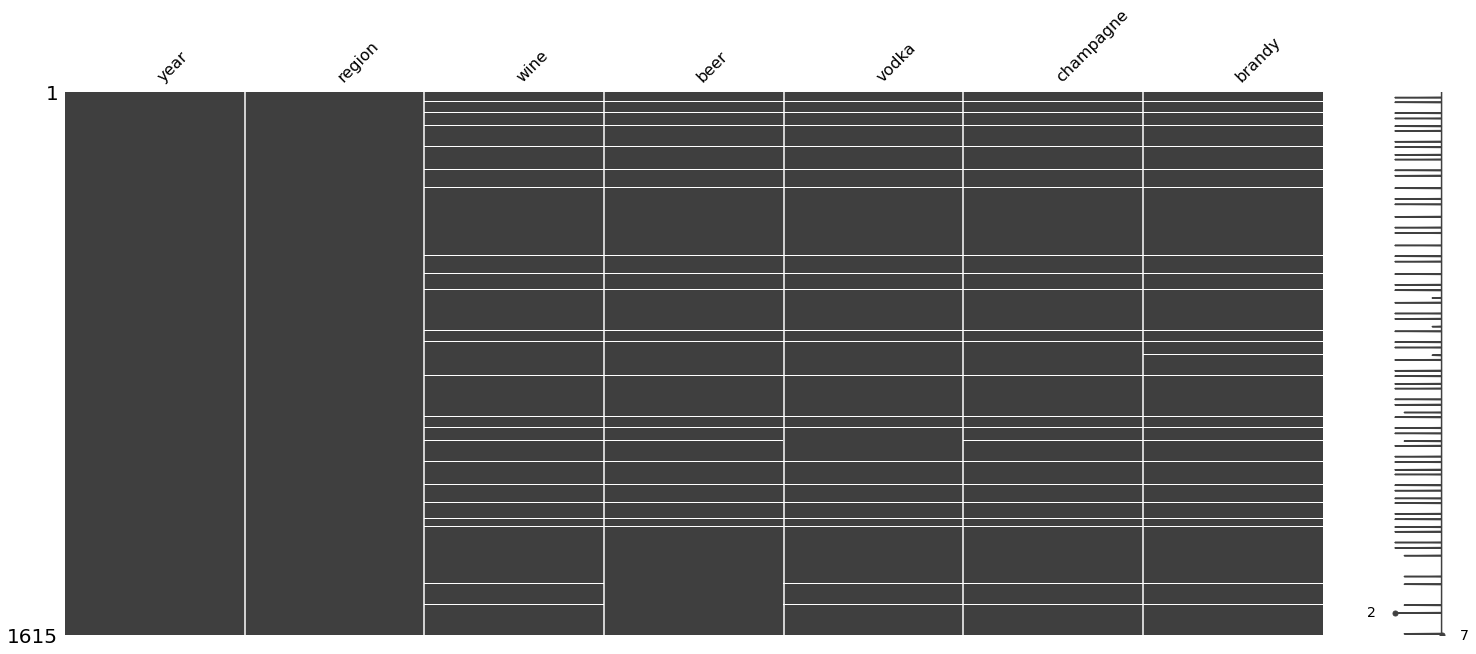

In [5]:
# Take a look at the dataset to see whether there is a missing value. (Here is sorted by years)
print(data.isna().sum())
msno.matrix(data)
plt.show()

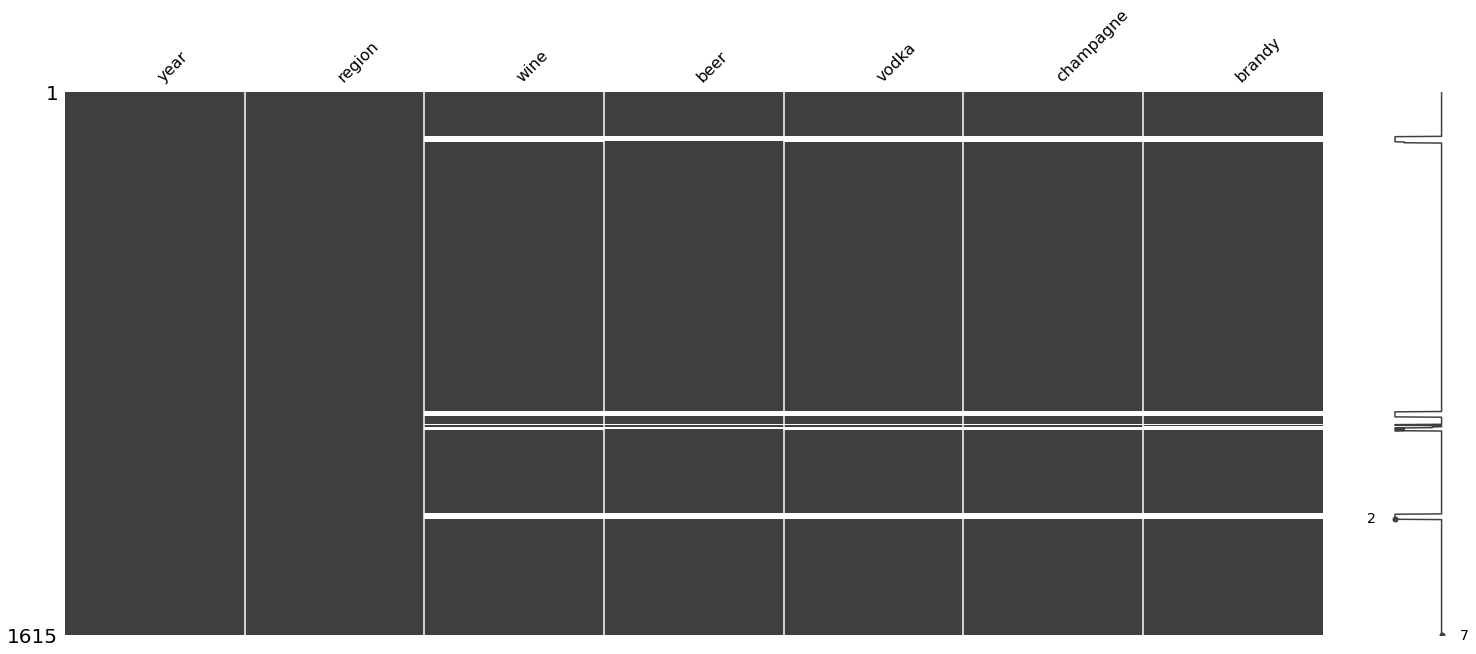

In [6]:
#Take another look in order to find a pattern of missing values (Sort by regions)
msno.matrix(data.sort_values(['region', 'year']))
plt.show()


It seems there is a pattern. When sorting the dataset by regions, the missing values gather together. Thus, the next step is to figure out what particular regions have missing values. Are these regions' data completely lost in all kinds of alcohol, or are only some data missing? If it is just partially missing, will it still be useful for further analysis?

In [7]:
#List the countries that have missing values.
data_sorted = data.sort_values(['region', 'year'])
data_na = data_sorted[data_sorted['brandy'].isna()]
print(data_na.groupby('region')['region'].unique())
data_na

region
Chechen Republic                [Chechen Republic]
Republic of Crimea            [Republic of Crimea]
Republic of Ingushetia    [Republic of Ingushetia]
Sevastopol                            [Sevastopol]
Name: region, dtype: object


,year,region,wine,beer,vodka,champagne,brandy
79,1998,Chechen Republic,NaN,NaN,NaN,NaN,NaN
164,1999,Chechen Republic,NaN,NaN,NaN,NaN,NaN
249,2000,Chechen Republic,NaN,NaN,NaN,NaN,NaN
334,2001,Chechen Republic,NaN,NaN,NaN,NaN,NaN
419,2002,Chechen Republic,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
998,2009,Sevastopol,NaN,NaN,NaN,NaN,NaN
1083,2010,Sevastopol,NaN,NaN,NaN,NaN,NaN
1168,2011,Sevastopol,NaN,NaN,NaN,NaN,NaN
1253,2012,Sevastopol,NaN,NaN,NaN,NaN,NaN


In [8]:
#Subset the data to contain the last three years' records, and then review whether there is still a missing value.
data_recent = data_duplicate.copy()
data_recent = data_recent[(data_recent['year'] >= 2014) & (data_recent['year'] <= 2016)]
data_recent[data_recent['brandy'].isna()]

,year,region,wine,beer,vodka,champagne,brandy
1377,2014,Republic of Ingushetia,NaN,0.4,NaN,NaN,NaN
1439,2014,Chechen Republic,NaN,4.9,NaN,NaN,NaN
1462,2015,Republic of Ingushetia,NaN,0.5,NaN,NaN,NaN
1524,2015,Chechen Republic,NaN,2.2,NaN,NaN,NaN
1547,2016,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
1609,2016,Chechen Republic,NaN,1.2,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 1360 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       249 non-null    int64  
 1   region     249 non-null    object 
 2   wine       249 non-null    float64
 3   beer       249 non-null    float64
 4   vodka      249 non-null    float64
 5   champagne  249 non-null    float64
 6   brandy     249 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 15.6+ KB
None


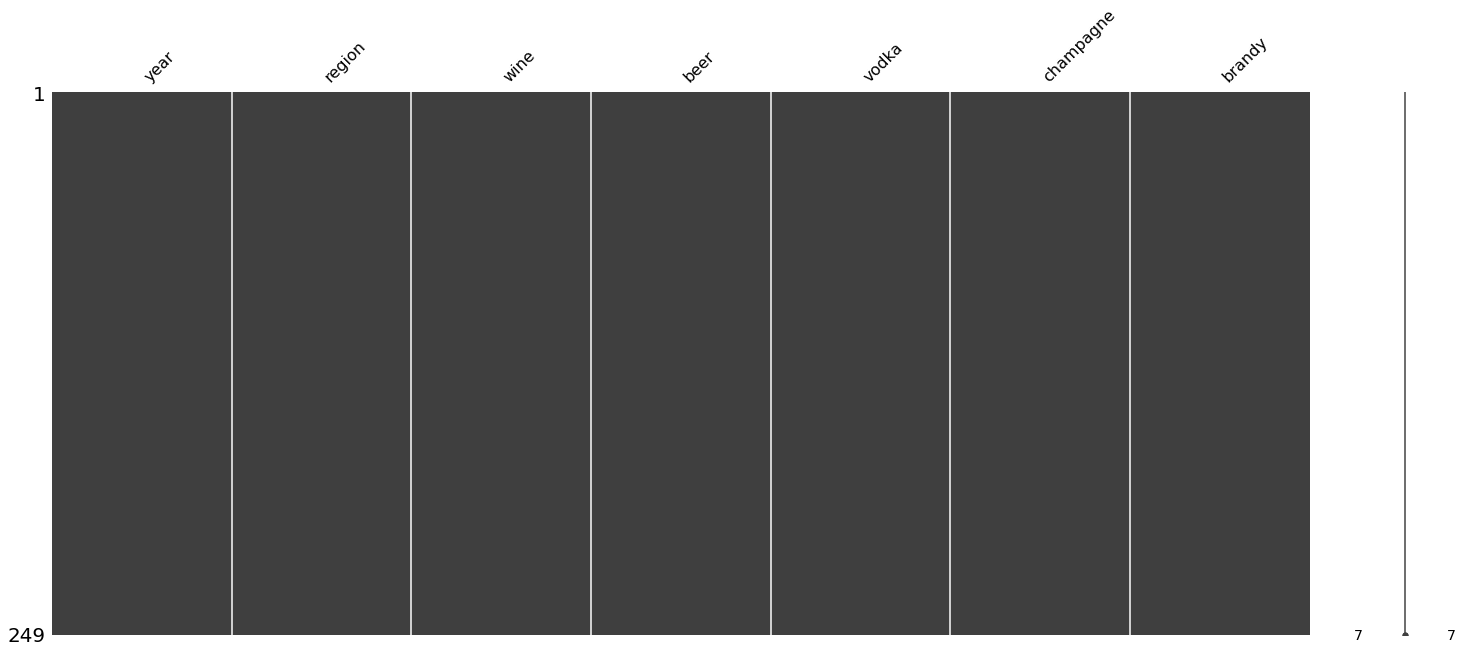

In [9]:
#Remove Chechen Republic and Republic of Ingushetia because they still have too many missing values.
data_recent = data_recent[(data_recent['region'] != 'Chechen Republic') & (data_recent['region'] != 'Republic of Ingushetia')]
print(data_recent.info())
msno.matrix(data_recent)
plt.show()


After removing the Chechen Republic and Republic of Ingushetia records, there is no missing value in the table. The first table containing all sales of different alcohol during the last three years is complete so far.

The next step is to prepare the other table containing the wine sales records at all times. Since some regions only lose partial sales records of wine, this step will fill the missing value by an average sales number.

Furthermore, because this table will be used for clustering based on the yearly sales trend, dividing the sales by the maximum sales number will force the sales of different regions to be in the same range. Thus, the clustering result will be affected by relative magnitude instead of the real sales numbers. 

In [10]:
#Get a list of all regions
region_list=[]
regions=[region_list.append(x_region) for x_region in data['region'] if x_region not in region_list]

#Fill the missing values of wine by the average numbers
for x in region_list:
    mean_num=data.loc[data['region'] == x, 'wine'].mean()
    data[data['region'] == x] = data[data['region'] == x].fillna({'wine': mean_num})

#Duplicate the table with the real sales numbers for further use.
data_sales = data.copy()

#Divide the sales by the maximum sales numbers of wine and make sure the maximum value is 1.
for y in region_list:
    max_num = data.loc[data['region'] == y, 'wine'].max()
    data.loc[data['region'] == y , 'wine'] = (data.loc[data['region']== y, 'wine'] / max_num).round(2)

print('The maximum value in Wine columns:', data['wine'].max())
data

The maximum value in Wine columns: 1.0


,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,0.28,8.8,3.4,0.3,0.1
1,1998,Altai Krai,0.69,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,0.28,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,0.35,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,0.48,18.0,9.5,0.8,0.2
...,...,...,...,...,...,...,...
1610,2016,Chuvash Republic,0.77,42.3,7.7,0.7,0.4
1611,2016,Chukotka Autonomous Okrug,0.41,34.0,11.6,1.8,1.1
1612,2016,Sakha (Yakutia) Republic,0.57,56.1,8.2,1.8,0.5
1613,2016,Yamalo-Nenets Autonomous Okrug,0.58,75.8,8.2,1.7,1.3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1615 non-null   int64  
 1   region     1615 non-null   object 
 2   wine       1596 non-null   float64
 3   beer       1557 non-null   float64
 4   vodka      1554 non-null   float64
 5   champagne  1552 non-null   float64
 6   brandy     1549 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 88.4+ KB
None


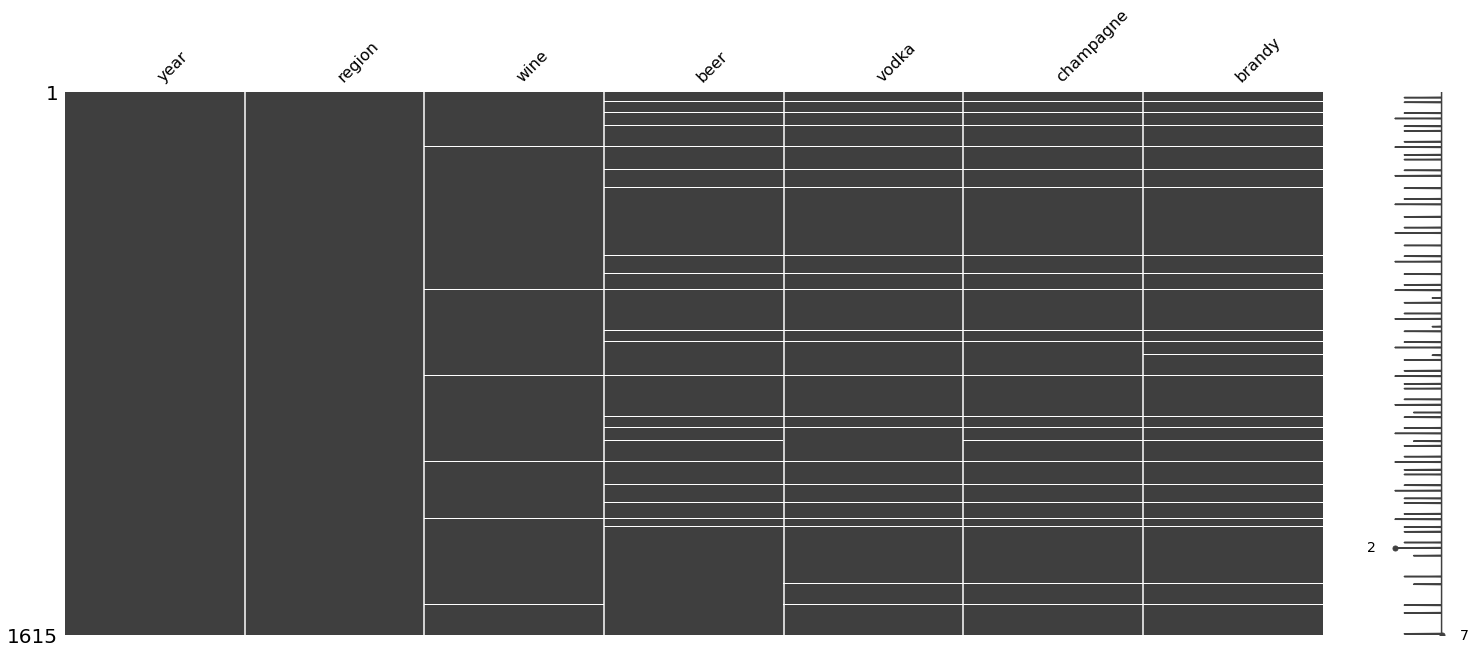

In [11]:
#Review whether there is still a missing value.
print(data.info())
msno.matrix(data)
plt.show()

In [12]:
#Find where the missing values are.
data[data['wine'].isna()]

,year,region,wine,beer,vodka,champagne,brandy
79,1998,Chechen Republic,NaN,NaN,NaN,NaN,NaN
164,1999,Chechen Republic,NaN,NaN,NaN,NaN,NaN
249,2000,Chechen Republic,NaN,NaN,NaN,NaN,NaN
334,2001,Chechen Republic,NaN,NaN,NaN,NaN,NaN
419,2002,Chechen Republic,NaN,NaN,NaN,NaN,NaN
504,2003,Chechen Republic,NaN,NaN,NaN,NaN,NaN
589,2004,Chechen Republic,NaN,NaN,NaN,NaN,NaN
674,2005,Chechen Republic,NaN,NaN,NaN,NaN,NaN
759,2006,Chechen Republic,NaN,NaN,NaN,NaN,NaN
844,2007,Chechen Republic,NaN,NaN,NaN,NaN,NaN


year      0
region    0
wine      0
dtype: int64


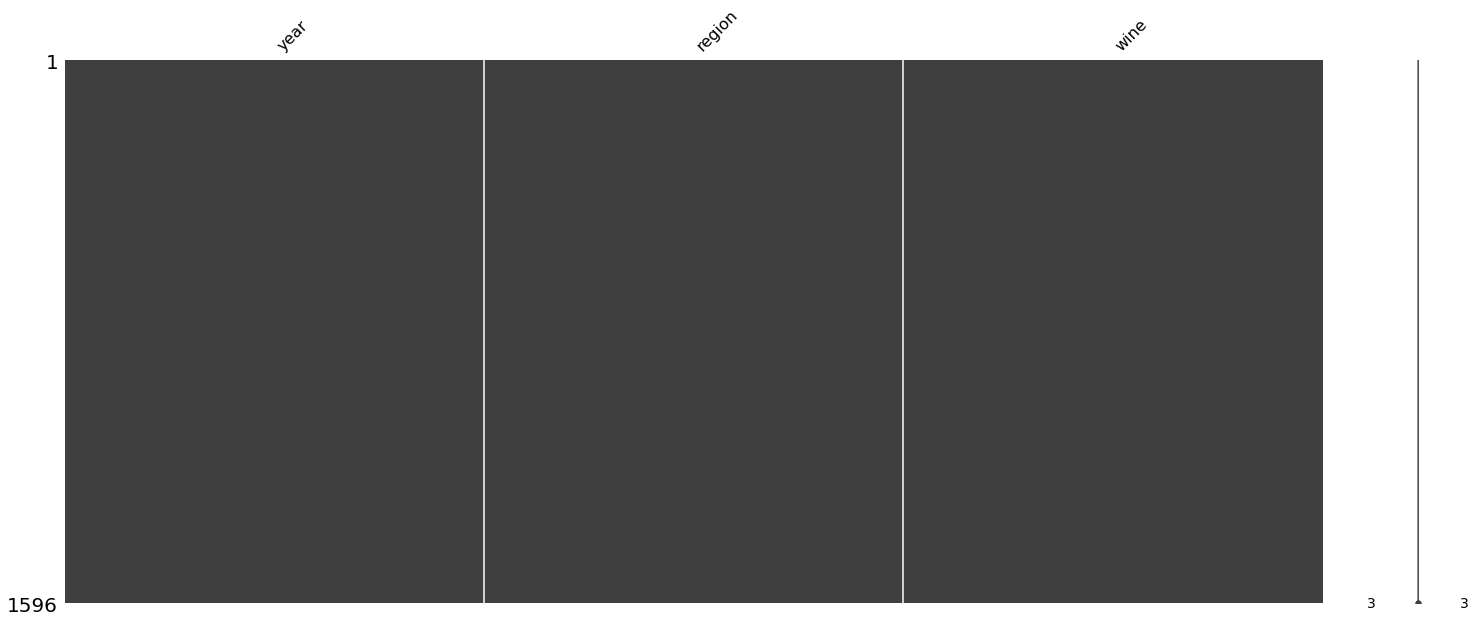

In [13]:
#Remove Chechen Republic which does not have any sales record of wine, and then remove the records of other alcohol.
data.dropna(subset = ["wine"], inplace=True)
data = data.drop(['beer', 'vodka', 'champagne', 'brandy'], axis=1)

#Make sure whether there is still a missing value.
print(data.isna().sum())
msno.matrix(data)
plt.show()


Now, the second table containing the historical sales of wine is complete. So far, there are two major tables for further clustering analysis as follows.

1. A table contains all wine sales records in relative magnitude at all times.
2. A table contains the average sales of different categories during the last three years.

## 3.2 EDA Summary
The given dataset has missing values. Most missing values are from 4 regions, Chechen Republic, Republic of Crimea, Republic of Ingushetia, and Sevastopol. The preparation process falls into two parts because this report would like to cluster the regions by two dimensions, the current sales combination of all alcohol and the wine sales trend.

Two regions do not have sales records during the last three years. Thus, the preparation of the first table is to remove the records of Chechen Republic and Republic of Ingushetia. Then, **"data_recent"** containing the average sales of different categories during the last three years is ready.

As for the other table, the further analysis aims to cluster the regions based on the sales trend of wine. Since some regions have partial missing records of wine, the preparation was to fill the missing value by an average sales number. Plus, in order to let the cluster by relative magnitude instead of the real sales numbers, the sales numbers were divided by the maximum number of wine sales. Then, "data" is cleaned by removing Chechen Republic, which does not have any sales record of wine. 

However, the "data" table still needs transformation to make it suitable for further clustering. Below **"data_pivot"** is the complete version for analysis.

In [14]:
#Use a pivot table to make years in columns and regions in rows.
data_pivot = data.pivot(index='region', columns='year', values='wine')
data_pivot

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Altai Krai,0.69,0.46,0.44,0.48,0.33,0.35,0.42,0.42,0.46,0.52,0.73,0.79,0.85,0.94,1.00,0.92,0.85,0.92,1.00
Altai Republic,0.51,0.72,0.81,0.85,0.85,0.96,1.00,0.90,0.60,0.72,0.90,0.82,0.91,0.85,0.78,0.63,0.63,0.64,0.67
Amur Oblast,0.28,0.38,0.32,0.34,0.30,0.70,0.68,0.76,0.78,0.75,0.86,0.91,1.00,0.95,0.76,0.88,0.80,0.79,0.82
Arkhangelsk Oblast,0.35,0.38,0.45,0.57,0.66,0.75,0.57,0.62,0.70,0.83,0.87,0.92,0.98,1.00,0.75,0.75,0.87,0.74,0.69
Astrakhan Oblast,0.48,0.62,0.61,0.62,0.67,0.74,0.79,0.69,0.64,0.67,0.82,0.97,1.00,0.81,0.77,0.69,0.84,0.77,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vologda Oblast,0.22,0.14,0.20,0.43,0.65,1.00,0.78,0.59,0.43,0.52,0.56,0.71,0.51,0.57,0.54,0.45,0.55,0.47,0.48
Voronezh Oblast,0.17,0.28,0.45,0.48,0.37,0.41,0.45,0.47,0.49,0.63,0.73,0.95,0.88,0.80,1.00,0.93,0.77,0.73,0.73
Yamalo-Nenets Autonomous Okrug,0.39,0.53,0.60,0.68,0.75,0.65,0.64,0.55,0.39,0.86,0.94,0.92,1.00,0.82,0.82,0.75,0.65,0.60,0.58


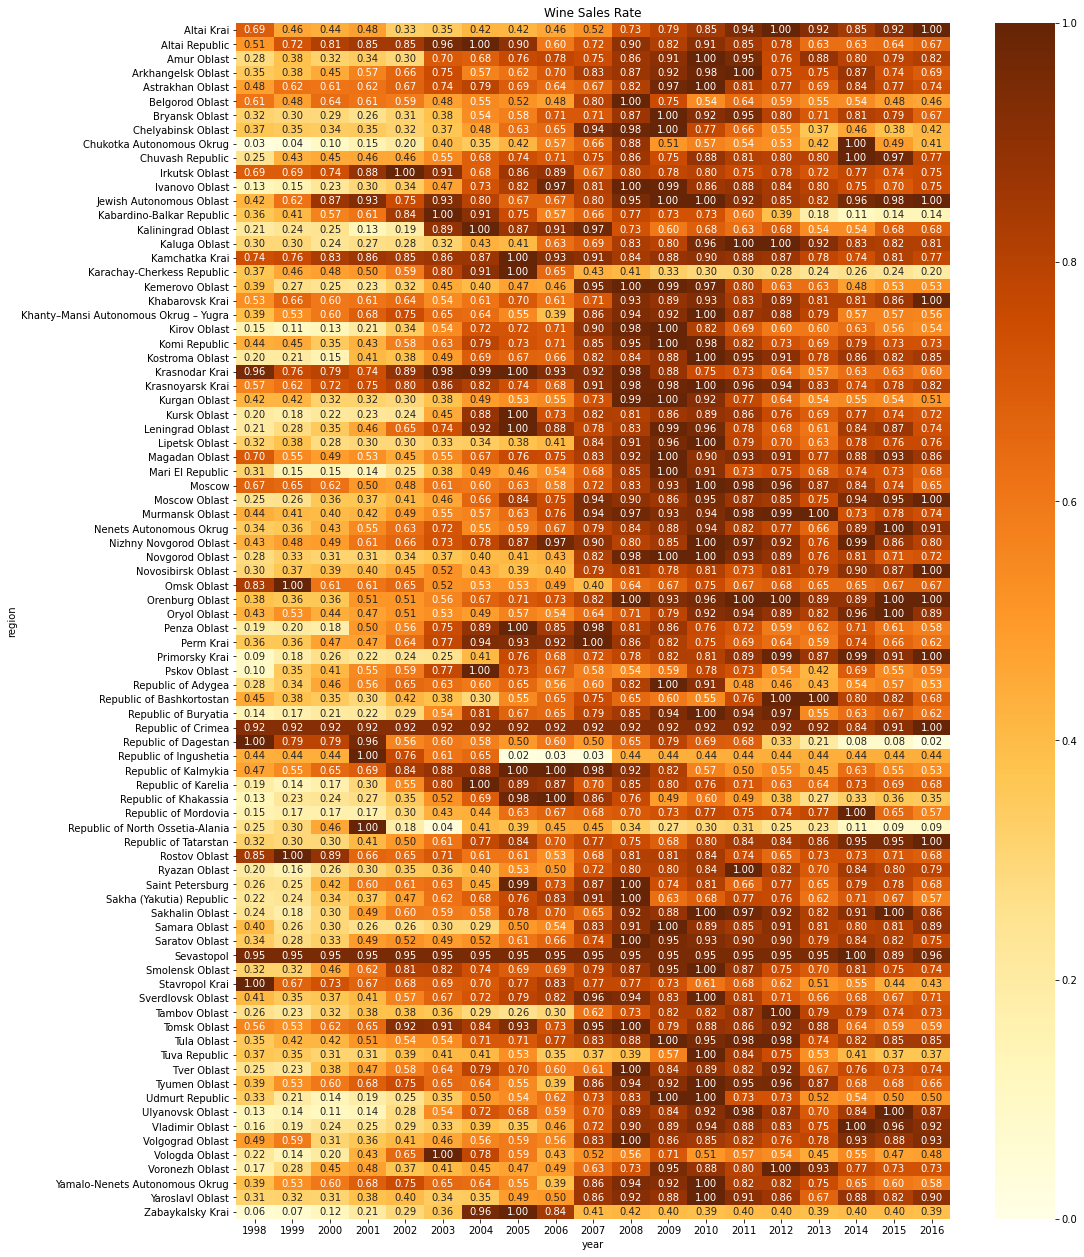

In [15]:
#Visualize the pivot table to see the sales trend in relative magnitude.
plt.subplots(figsize=(16, 22))
ax = sns.heatmap(data_pivot, annot=True, fmt='.2f', vmin=0.0, vmax=1.0, cmap='YlOrBr')
plt.title('Wine Sales Rate')
plt.show()

# 4. Analyze
In order to cluster regions by a time series of wine sales, this report will use K-means clustering. The K-means algorithm would allow the clustering process to allocate every data point to the nearest cluster with the shortest distance between points and the centroids (Garbade, 2018). Thus, by using K-means clustering, this report is able to split the regions into different groups having similar buying behavior of wine based on the sales trend.

However, before starting K-means clustering, figuring out the ideal number of clusters is required. Too few clusters would cause the entities in a group to have many different traits. Too many groups would cause that there is not much difference between groups. Therefore, this section proceeds with the Elbow method in order to determine the best number of clusters.

In [16]:
#Import packages for clustering purposes
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

## 4.1 Elbow Method

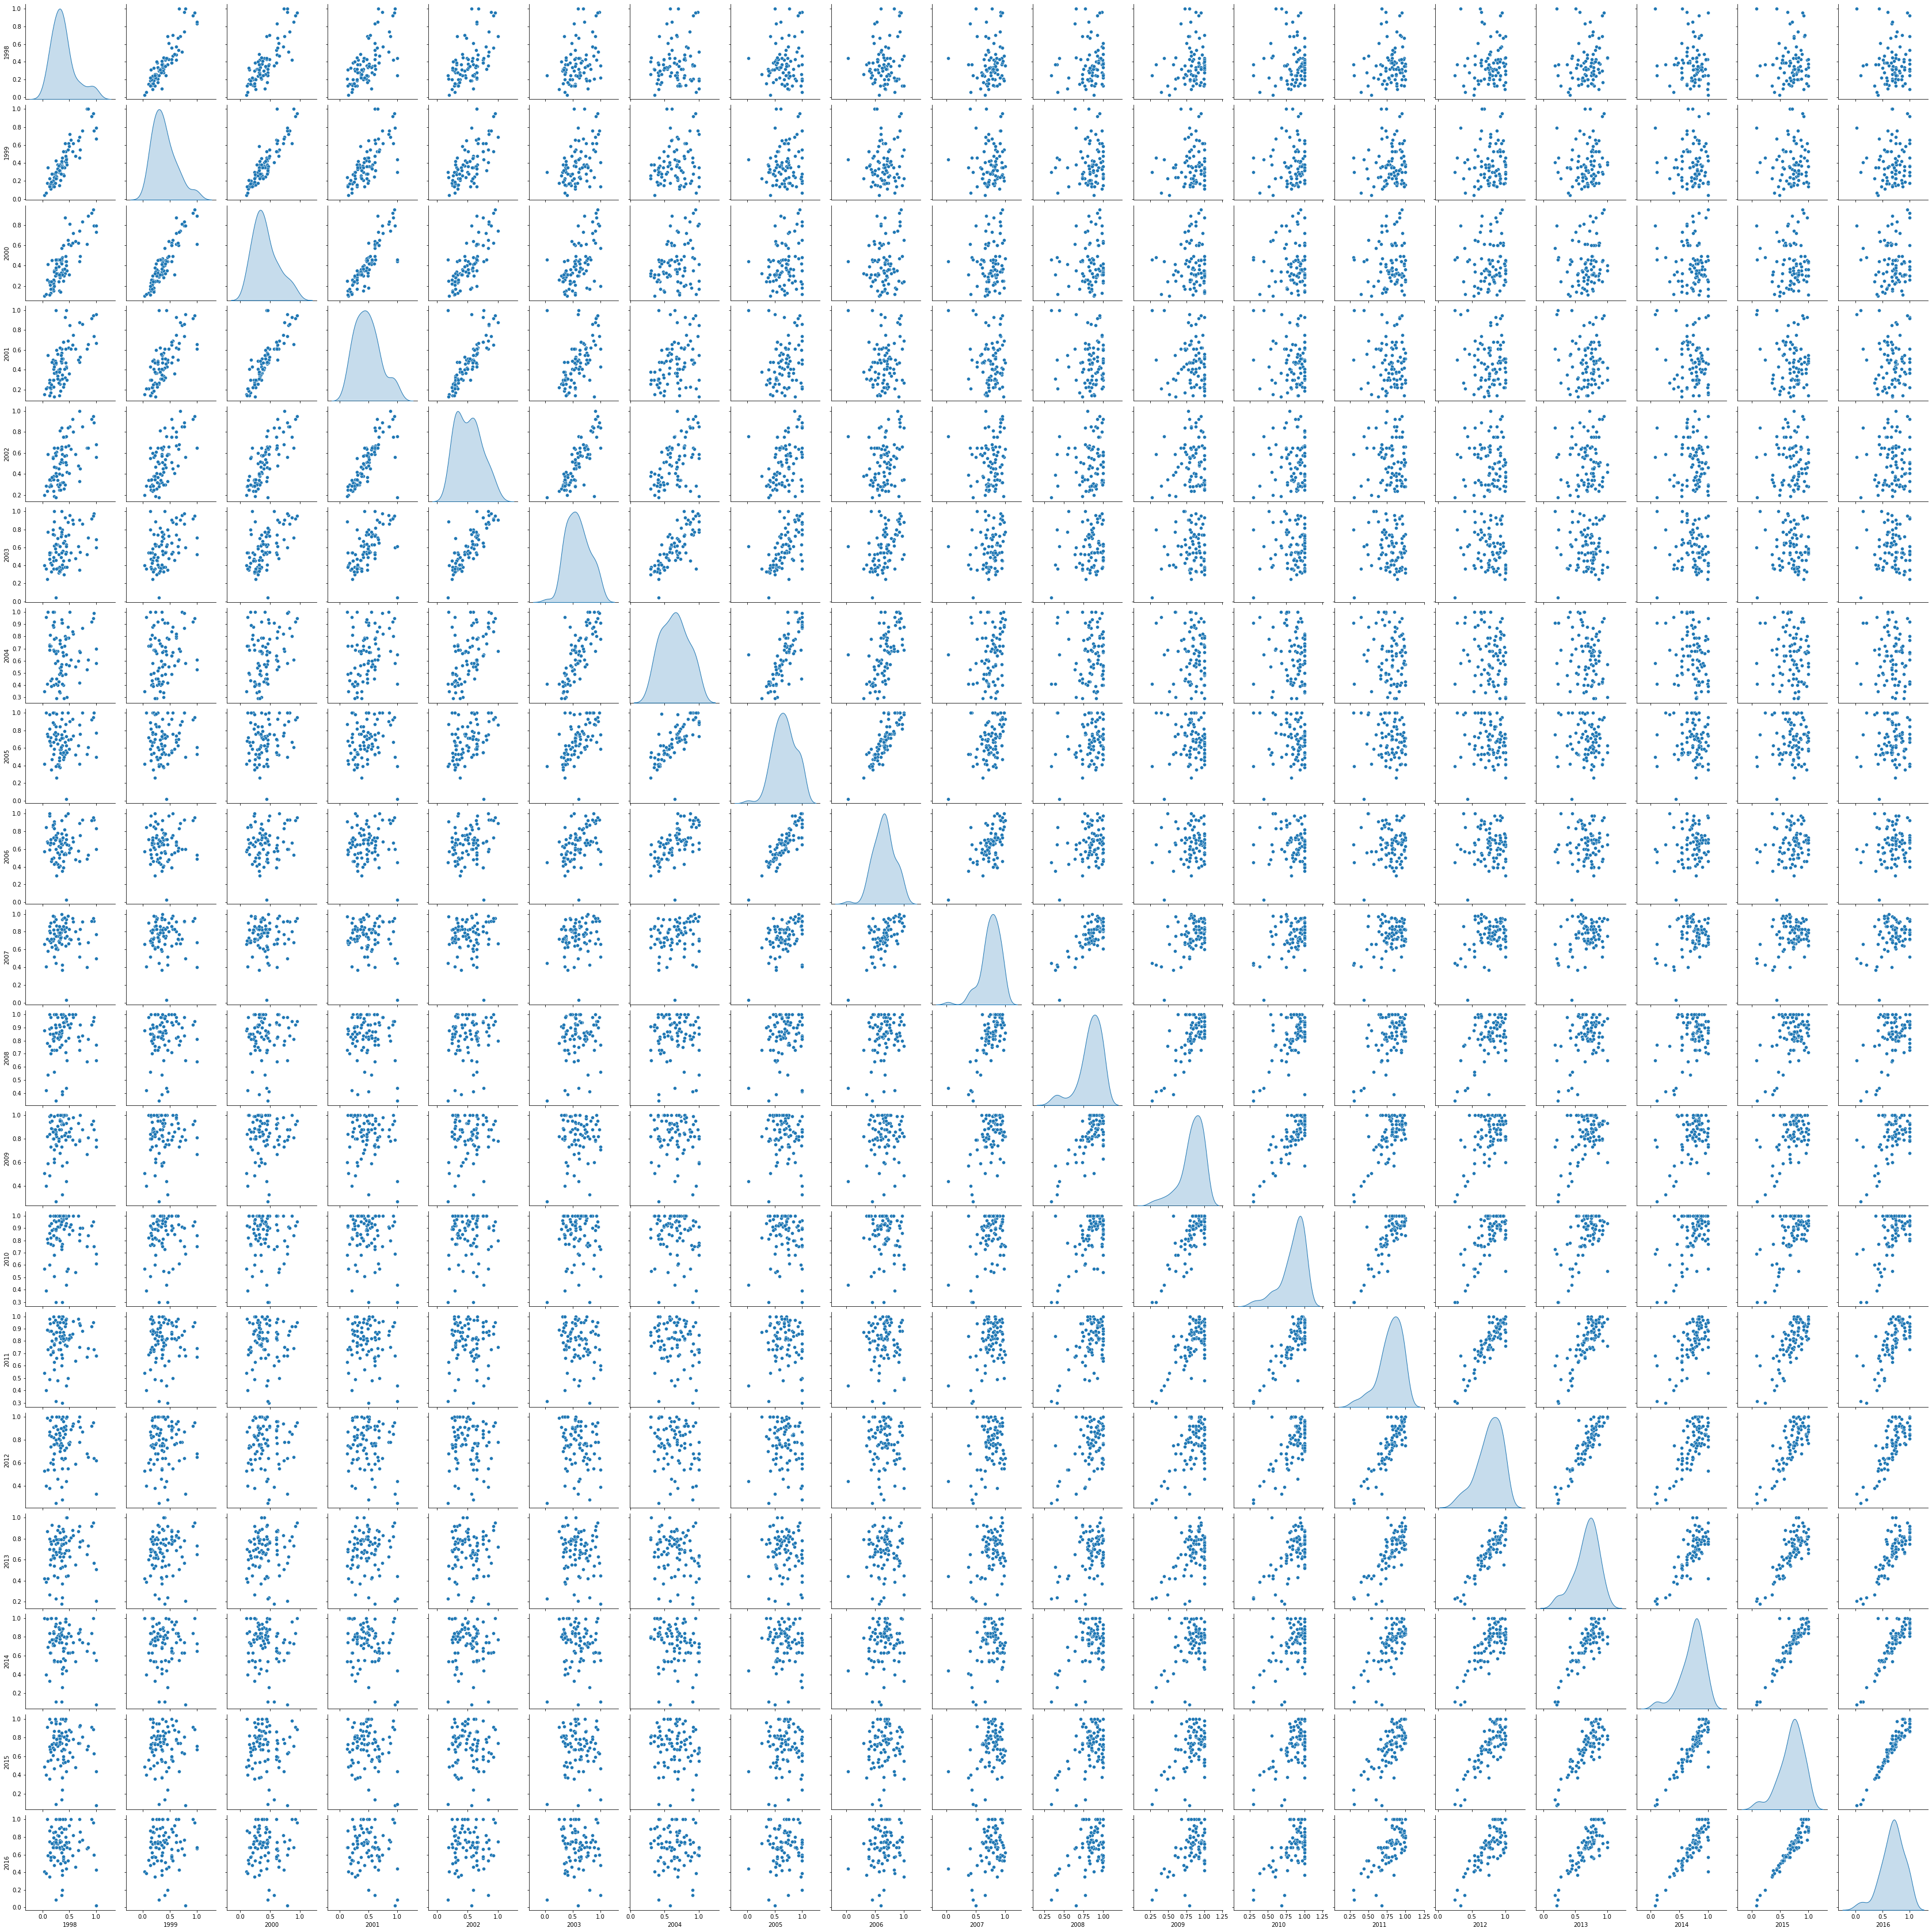

In [17]:
#Visualize the distribution of the sales in different years
sns.pairplot(data_pivot, diag_kind='kde')
plt.show()


**"data_pivot"** seems the distributions of the variables are not quite skewed. Since K-means clustering works better on variables with almost the same mean and variance, the variables in this table look acceptable for further analysis. However, the below normalization shows the normalized table is also good for K-means clustering. Thus, this report will keep using the normalized table for the analysis.

In [18]:
#Normalize the table and review the mean and standard deviation of the table
scaler=StandardScaler()
scaler.fit(data_pivot)
pivot_normalized = scaler.transform(data_pivot)
pivot_normalized = pd.DataFrame(data=pivot_normalized, index=data_pivot.index, columns=data_pivot.columns)
pivot_normalized.agg(['mean', 'std']).round()

,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
mean,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


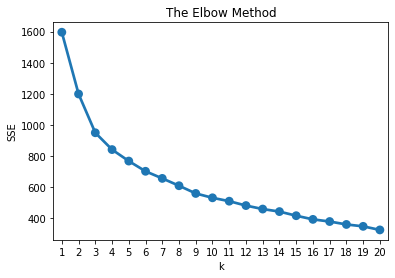

In [19]:
#Visualize the SSE to choose the point with the sharpest angle.
sse={}
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(pivot_normalized)
    sse[k] = kmeans.inertia_

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

## 4.2 K-means Clustering
Regarding the outcome of the Elbow method, it is clear that 4 clusters are the ideal solution for this situation. As a result, this analysis splits regions into 4 clusters and then visualizes the buying behavior of the regions in different clusters. The heatmap shows 17 regions have the same buying behavior of wine as Saint Petersburg that the customers buy more wine between 2003 to 2011.

In [20]:
#Split regions into 4 clusters by K-means clustering.
kmeans = KMeans(n_clusters=4, random_state=44)
kmeans.fit(pivot_normalized)
cluster_labels = kmeans.labels_

data_cluster = data_pivot.assign(cluster=cluster_labels)
data_cluster = data_cluster.reset_index()
data_cluster.columns.name = None
data_cluster.head()

,region,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,cluster
0,Altai Krai,0.69,0.46,0.44,0.48,0.33,0.35,0.42,0.42,0.46,...,0.73,0.79,0.85,0.94,1.00,0.92,0.85,0.92,1.00,0
1,Altai Republic,0.51,0.72,0.81,0.85,0.85,0.96,1.00,0.90,0.60,...,0.90,0.82,0.91,0.85,0.78,0.63,0.63,0.64,0.67,3
2,Amur Oblast,0.28,0.38,0.32,0.34,0.30,0.70,0.68,0.76,0.78,...,0.86,0.91,1.00,0.95,0.76,0.88,0.80,0.79,0.82,0
3,Arkhangelsk Oblast,0.35,0.38,0.45,0.57,0.66,0.75,0.57,0.62,0.70,...,0.87,0.92,0.98,1.00,0.75,0.75,0.87,0.74,0.69,0
4,Astrakhan Oblast,0.48,0.62,0.61,0.62,0.67,0.74,0.79,0.69,0.64,...,0.82,0.97,1.00,0.81,0.77,0.69,0.84,0.77,0.74,3


In [21]:
#Find out the cluster number of Saint Petersburg
data_cluster[data_cluster['region'] == 'Saint Petersburg']

,region,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,cluster
60,Saint Petersburg,0.26,0.25,0.42,0.6,0.61,0.63,0.45,0.99,0.73,...,1.0,0.74,0.81,0.66,0.77,0.65,0.79,0.78,0.68,1


In [22]:
#Get the region names where the buying behavior is similar to Saint Petersburg
data_cluster_list = data_cluster.loc[data_cluster['cluster'] == 1, 'region'].to_numpy()
print(len(data_cluster_list))
data_cluster_list

17


array(['Belgorod Oblast', 'Chelyabinsk Oblast',
       'Chukotka Autonomous Okrug', 'Kaliningrad Oblast', 'Kirov Oblast',
       'Kursk Oblast', 'Leningrad Oblast', 'Penza Oblast', 'Perm Krai',
       'Pskov Oblast', 'Republic of Adygea', 'Republic of Kalmykia',
       'Republic of Karelia', 'Republic of Khakassia', 'Saint Petersburg',
       'Sakha (Yakutia) Republic', 'Sverdlovsk Oblast'], dtype=object)

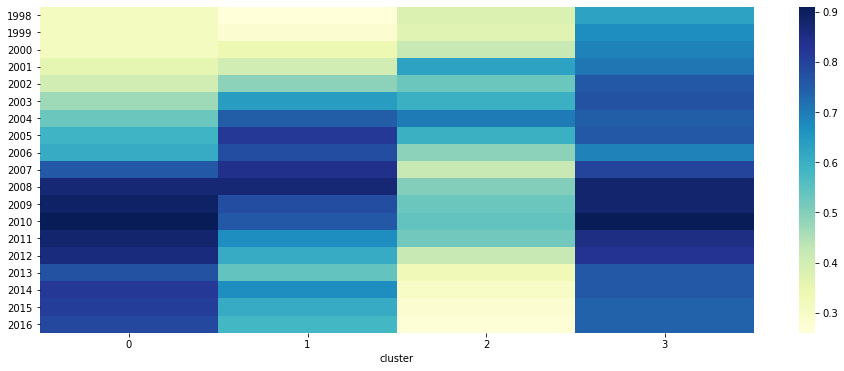

In [23]:
#Visualize the table to understand the buying behavor of different clusters
kmeans_avg = data_cluster.groupby(['cluster']).mean().round(2)

plt.subplots(figsize=(16, 6))
sns.heatmap(kmeans_avg.T, cmap = 'YlGnBu')
plt.show()


With regards to the heatmap above, the regions of cluster 0 have a peak of purchasing wine between 2007 and 2016. Cluster 1 buys more wine from 2003 to 2011. Cluster 2 has steady buying behavior that there are no obviously huge sales in the history. In contrast, cluster 3 has steady high wine sales at all times.

## 4.3 Top 10 Regions
In order to select 10 potential regions from the 17 regions in cluster 1, this section is to pick the most valuable regions by regression analysis and the actual sales numbers. First, the higher the correlation coefficient, the higher the potential profit. A positive correlation coefficient means the sales number increases every year. Thus, the correlation coefficient will be one criterion to select regions.

Another criterion is the actual sales of the regions. The previous clustering uses relative magnitude to cluster regions by the sales trend of wine in years. However, in this way, the regions in cluster 1 may not have as high sales as Saint Petersburg. Thus, further analysis will calculate average sales during the last three years and then rank regions by these sales numbers as well as the correlation coefficients.

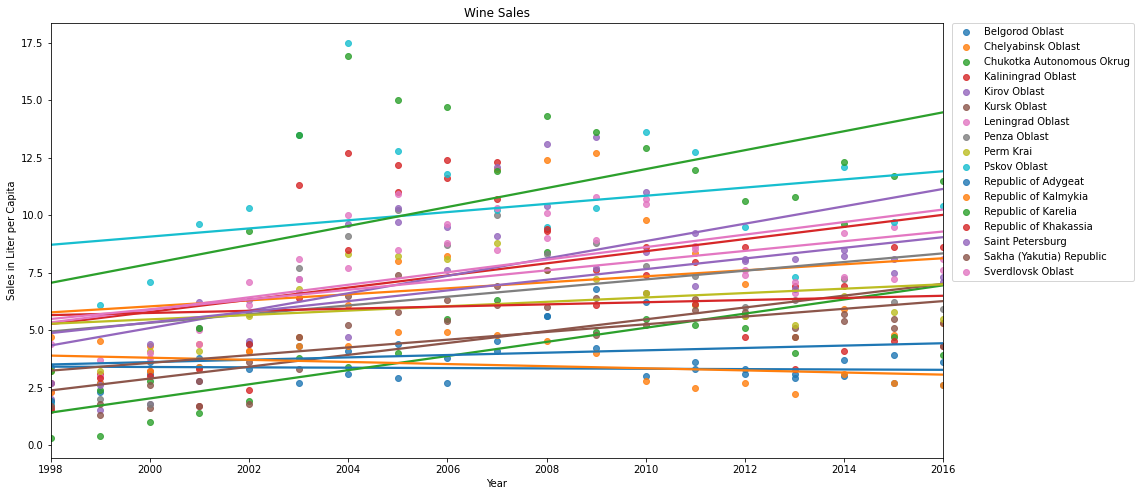

In [24]:
#Visualize the regression lines of the regions in cluster 1 in order to take a quick look
plt.subplots(figsize=(16, 8))

g1 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Belgorod Oblast'], x='year', y='wine', order=1, ci=False, label='Belgorod Oblast')
g2 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Chelyabinsk Oblast'], x='year', y='wine', order=1, ci=False, label='Chelyabinsk Oblast')
g3 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Chukotka Autonomous Okrug'], x='year', y='wine', order=1, ci=False, label='Chukotka Autonomous Okrug')
g4 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Kaliningrad Oblast'], x='year', y='wine', order=1, ci=False, label='Kaliningrad Oblast')
g5 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Kirov Oblast'], x='year', y='wine', order=1, ci=False, label='Kirov Oblast')
g6 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Kursk Oblast'], x='year', y='wine', order=1, ci=False, label='Kursk Oblast')
g7 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Leningrad Oblast'], x='year', y='wine', order=1, ci=False, label='Leningrad Oblast')
g8 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Penza Oblast'], x='year', y='wine', order=1, ci=False, label='Penza Oblast')
g9 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Perm Krai'], x='year', y='wine', order=1, ci=False, label='Perm Krai')
g10 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Pskov Oblast'], x='year', y='wine', order=1, ci=False, label='Pskov Oblast')
g11 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Republic of Adygea'], x='year', y='wine', order=1, ci=False, label='Republic of Adygeat')
g12 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Republic of Kalmykia'], x='year', y='wine', order=1, ci=False, label='Republic of Kalmykia')
g13= sns.regplot(data=data_sales.loc[data_sales['region'] == 'Republic of Karelia'], x='year', y='wine', order=1, ci=False, label='Republic of Karelia')
g14 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Republic of Khakassia'], x='year', y='wine', order=1, ci=False, label='Republic of Khakassia')
g15 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Saint Petersburg'], x='year', y='wine', order=1, ci=False, label='Saint Petersburg')
g16 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Sakha (Yakutia) Republic'], x='year', y='wine', order=1, ci=False, label='Sakha (Yakutia) Republic')
g17 = sns.regplot(data=data_sales.loc[data_sales['region'] == 'Sverdlovsk Oblast'], x='year', y='wine', order=1, ci=False, label='Sverdlovsk Oblast')

g1.set_title('Wine Sales', y=1)
g1.set(xlabel='Year', ylabel='Sales in Liter per Capita')
plt.locator_params(axis="x", nbins=10)
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

In [25]:
#Make a pivot table for actual sales of wine.
data_sales = data_sales.drop(['beer', 'vodka', 'champagne', 'brandy'], axis=1)
data_sales.dropna(subset = ["wine"], inplace=True)
data_sales_pivot = data_sales.pivot(index='region', columns='year', values='wine')
data_sales_pivot.head()

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Altai Krai,3.3,2.2,2.1,2.3,1.6,1.7,2.0,2.0,2.2,2.5,3.5,3.8,4.1,4.51,4.8,4.4,4.1,4.4,4.8
Altai Republic,3.4,4.8,5.4,5.7,5.7,6.4,6.7,6.0,4.0,4.8,6.0,5.5,6.1,5.71,5.2,4.2,4.2,4.3,4.5
Amur Oblast,2.1,2.9,2.4,2.6,2.3,5.3,5.2,5.8,5.9,5.7,6.5,6.9,7.6,7.21,5.8,6.7,6.1,6.0,6.2
Arkhangelsk Oblast,4.3,4.6,5.5,7.0,8.1,9.2,7.0,7.6,8.6,10.1,10.7,11.3,12.0,12.23,9.2,9.2,10.7,9.0,8.4
Astrakhan Oblast,2.9,3.8,3.7,3.8,4.1,4.5,4.8,4.2,3.9,4.1,5.0,5.9,6.1,4.92,4.7,4.2,5.1,4.7,4.5


In [26]:
#Acquire the correlation coefficients of the regions.
data_sales_pivot = data_sales_pivot.reset_index()
data_sales_pivot.columns.name = None

region_list = data_sales_pivot['region'].to_numpy()
lin_reg = LinearRegression()

reg_list=[]
for z in region_list:
  reg_df = data_sales[data_sales['region'] == z]
  X = reg_df[['year']]
  y = reg_df[['wine']]
  lin_reg.fit(X, y)
  reg_list.append(lin_reg.coef_)

coef_list = np.array(reg_list).flatten()
data_sales_pivot = data_sales_pivot.assign(coef=coef_list)

#Calculate the average sales during the last three years.
data_sales_pivot['avg_wine_12-16'] = data_sales_pivot.iloc[:, 15:20].mean(axis=1).round(2)
data_sales_pivot.head()

,region,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2009,2010,2011,2012,2013,2014,2015,2016,coef,avg_wine_12-16
0,Altai Krai,3.3,2.2,2.1,2.3,1.6,1.7,2.0,2.0,2.2,...,3.8,4.1,4.51,4.8,4.4,4.1,4.4,4.8,0.168667,4.50
1,Altai Republic,3.4,4.8,5.4,5.7,5.7,6.4,6.7,6.0,4.0,...,5.5,6.1,5.71,5.2,4.2,4.2,4.3,4.5,-0.030807,4.48
2,Amur Oblast,2.1,2.9,2.4,2.6,2.3,5.3,5.2,5.8,5.9,...,6.9,7.6,7.21,5.8,6.7,6.1,6.0,6.2,0.258491,6.16
3,Arkhangelsk Oblast,4.3,4.6,5.5,7.0,8.1,9.2,7.0,7.6,8.6,...,11.3,12.0,12.23,9.2,9.2,10.7,9.0,8.4,0.287404,9.30
4,Astrakhan Oblast,2.9,3.8,3.7,3.8,4.1,4.5,4.8,4.2,3.9,...,5.9,6.1,4.92,4.7,4.2,5.1,4.7,4.5,0.082246,4.64


In [27]:
#Keep only correlation coefficients and sales.
data_cm = data_sales_pivot.copy(deep=True)
data_cm = data_cm[['region', 'coef', 'avg_wine_12-16']]
data_cm

,region,coef,avg_wine_12-16
0,Altai Krai,0.168667,4.50
1,Altai Republic,-0.030807,4.48
2,Amur Oblast,0.258491,6.16
3,Arkhangelsk Oblast,0.287404,9.30
4,Astrakhan Oblast,0.082246,4.64
...,...,...,...
79,Vologda Oblast,0.154842,9.02
80,Voronezh Oblast,0.273649,6.26
81,Yamalo-Nenets Autonomous Okrug,0.087930,5.24
82,Yaroslavl Oblast,0.453123,9.34


In [28]:
#Subset the correlation coefficients and sales into 3 levels.
data_cm['coef_level']=pd.qcut(data_cm['coef'].rank(method='first'), q=3, labels=range(1,4))
data_cm['avg_wine_level']=pd.qcut(data_cm['avg_wine_12-16'].rank(method='first'), q=3, labels=range(1,4))
data_cm.head()

,region,coef,avg_wine_12-16,coef_level,avg_wine_level
0,Altai Krai,0.168667,4.50,2,1
1,Altai Republic,-0.030807,4.48,1,1
2,Amur Oblast,0.258491,6.16,2,2
3,Arkhangelsk Oblast,0.287404,9.30,3,3
4,Astrakhan Oblast,0.082246,4.64,1,1


In [29]:
#Give a final score by summing up the coefficients and sales levels
data_cm['score'] = data_cm[['coef_level', 'avg_wine_level']].sum(axis=1).astype(int)

def cm_level_func(df):
  if df['score'] >= 5:
    return 'Top'
  elif ((df['score'] >= 3) & (df['score'] < 5)):
    return 'Middle'
  else:
    return 'Low'
data_cm['cm_level'] = data_cm.apply(cm_level_func, axis=1)

data_cm.head()

,region,coef,avg_wine_12-16,coef_level,avg_wine_level,score,cm_level
0,Altai Krai,0.168667,4.50,2,1,3,Middle
1,Altai Republic,-0.030807,4.48,1,1,2,Low
2,Amur Oblast,0.258491,6.16,2,2,4,Middle
3,Arkhangelsk Oblast,0.287404,9.30,3,3,6,Top
4,Astrakhan Oblast,0.082246,4.64,1,1,2,Low


In [30]:
#Add cluster labels into this data frame.
data_cluster_label = data_cluster[['region', 'cluster']]
data_label_scatter = data_cm.merge(data_cluster_label, how='inner', on = 'region')

#Review the number of regions at different levels.
print(data_label_scatter.groupby('cm_level').agg({'coef': 'mean', 'avg_wine_12-16': ['mean', 'count']}).round(2))
data_label_scatter.head()

          coef avg_wine_12-16      
          mean           mean count
cm_level                           
Low      -0.01           3.48    20
Middle    0.15           5.56    27
Top       0.32           7.91    37


,region,coef,avg_wine_12-16,coef_level,avg_wine_level,score,cm_level,cluster
0,Altai Krai,0.168667,4.50,2,1,3,Middle,0
1,Altai Republic,-0.030807,4.48,1,1,2,Low,3
2,Amur Oblast,0.258491,6.16,2,2,4,Middle,0
3,Arkhangelsk Oblast,0.287404,9.30,3,3,6,Top,0
4,Astrakhan Oblast,0.082246,4.64,1,1,2,Low,3


In [31]:
#Scatter plot shows the distribution of the regions in different clusters
data_label_scatter['cluster'] = data_label_scatter['cluster'].astype(str)
fig = px.scatter(data_label_scatter, x = 'coef', y='avg_wine_12-16', labels={
                     "coef": "Coeffiecient",
                     "avg_wine_12-16": "Average Wine Sales in Liter"
                 },
                 color='cluster', hover_data=['region'], color_discrete_map = {"0": "blue", "1": "orange", "2":"red", '3':'black'})
fig.show()

In [32]:
#Sort the top 10 regions by the score number
data_filtered = data_label_scatter[data_label_scatter['region'].isin(data_cluster_list)]
data_top10 = data_filtered.sort_values('score', ascending=False).head(10)
data_top10

,region,coef,avg_wine_12-16,coef_level,avg_wine_level,score,cm_level,cluster
53,Republic of Karelia,0.412316,11.38,3,3,6,Top,1
21,Kirov Oblast,0.378456,7.90,3,3,6,Top,1
28,Leningrad Oblast,0.272912,8.16,3,3,6,Top,1
68,Sverdlovsk Oblast,0.211544,7.36,2,3,5,Top,1
8,Chukotka Autonomous Okrug,0.307579,5.46,3,2,5,Top,1
14,Kaliningrad Oblast,0.264070,7.92,2,3,5,Top,1
45,Pskov Oblast,0.177895,9.80,2,3,5,Top,1
60,Saint Petersburg,0.231930,7.64,2,3,5,Top,1
27,Kursk Oblast,0.257754,5.44,2,2,4,Middle,1
42,Penza Oblast,0.188912,6.32,2,2,4,Middle,1



So far, by sorting the score numbers, the above table clearly shows the top 10 regions where the next wine promotion should proceed. The below scatter plot demonstrates the distribution of these 10 regions.

In [33]:
#Visualize the distribution of the top 10 regions
fig=go.Figure()
fig.add_trace(
    go.Scatter(x=data_cm['coef'], y=data_cm['avg_wine_12-16'], name='All Regions', mode='markers', opacity=0.4)
)
fig.add_trace(
    go.Scatter(x=data_top10['coef'], y=data_top10['avg_wine_12-16'], name='Top 10 Regions', mode='markers')
)

annotaion_01={'x':'0.412316', 'y':'11.38', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':4,'text':'Republic of Karelia', 'textangle':-90, 'font':{'size':10, 'color':'green'}}
annotaion_02={'x':'0.378456', 'y':'7.90', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':4,'text':'Kirov Oblast', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_03={'x':'0.272912', 'y':'8.16', 'showarrow':False, 'arrowhead':4, 'xshift':-2,'yshift':48,'text':'Leningrad Oblast', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_04={'x':'0.211544', 'y':'7.36', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':4,'text':'Sverdlovsk Oblast', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_05={'x':'0.307579', 'y':'5.46', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':4,'text':'Chukotka Autonomous Okrug', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_06={'x':'0.264070', 'y':'7.92', 'showarrow':False, 'arrowhead':4, 'xshift':-4,'yshift':52,'text':'Kaliningrad Oblast', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_07={'x':'0.177895', 'y':'9.80', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':4,'text':'Pskov Oblast', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_08={'x':'0.231930', 'y':'7.64', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':4,'text':'Saint Petersburg', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_09={'x':'0.257754', 'y':'5.44', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':4,'text':'Kursk Oblast', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_10={'x':'0.188912', 'y':'6.32', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':4,'text':'Penza Oblast', 'textangle':-90,'font':{'size':10, 'color':'green'}}

fig.update_layout({ 
    'annotations':[annotaion_01, annotaion_02, annotaion_03,
      annotaion_04, annotaion_05, annotaion_06,
      annotaion_07, annotaion_08, annotaion_09, annotaion_10], 
      'showlegend':True, 'legend':{'x':0.02, 'y':0.96, 'bgcolor':'rgb(246, 228, 129)'}
      })
fig.update_xaxes(
        title_text = "Coeffiecient",
        title_font = {"size": 16},
        title_standoff = 12)
fig.update_yaxes(
        title_text = "Average Wine Sales in Liter",
        title_font = {"size": 16},
        title_standoff = 12)
fig.show()


The K-mean clustering helps select regions by the sales trend of wine. Also, the coefficients and sales numbers help give scores for ranking. Because of this, this report is able to pick the top 10 regions for the next wine promotion.

However, it is beneficial to see a different result by taking into account all kinds of alcohol. Thus, the next section will use another clustering method to find the regions similar to Saint Petersburg in terms of the sales of different alcohol.

## 4.4 Hierarchical Clustering
**"data_recent"** contains the sales records during the last three years when the previous Process phase. Next, this section groups the table by regions and get the average recent sales of different alcohol. By looking at the dendrogram of hierarchical clustering, splitting regions into 4 clusters is an option. If reducing the number of clusters, the hierarchical distance will be too long that there is much difference between clusters.

The cluster with Saint Petersburg has 34 regions. By comparing the hierarchical clustering and K-means clustering results, this report is able to come out 6 high priority regions out of the top 10 regions. This approach is also beneficial for operation and project management to arrange the priority of tasks.

In [34]:
#Group the table by regions and get the average sales during the last three years.
data_recent_group = data_recent.groupby('region').agg({'wine':'mean', 'beer':'mean', 'vodka':'mean', 'champagne':'mean', 'brandy':'mean'}).round(2)
data_recent_group

,wine,beer,vodka,champagne,brandy
region,,,,,
Altai Krai,4.43,45.20,4.83,0.87,0.30
Altai Republic,4.33,40.50,7.70,1.13,0.33
Amur Oblast,6.10,53.87,7.00,1.53,0.53
Arkhangelsk Oblast,9.37,55.03,12.27,1.87,0.93
Astrakhan Oblast,4.77,46.20,5.00,0.93,0.63
...,...,...,...,...,...
Vologda Oblast,9.03,45.23,10.10,1.17,0.60
Voronezh Oblast,5.60,52.80,4.43,1.43,0.57
Yamalo-Nenets Autonomous Okrug,4.70,81.57,9.00,1.87,1.37


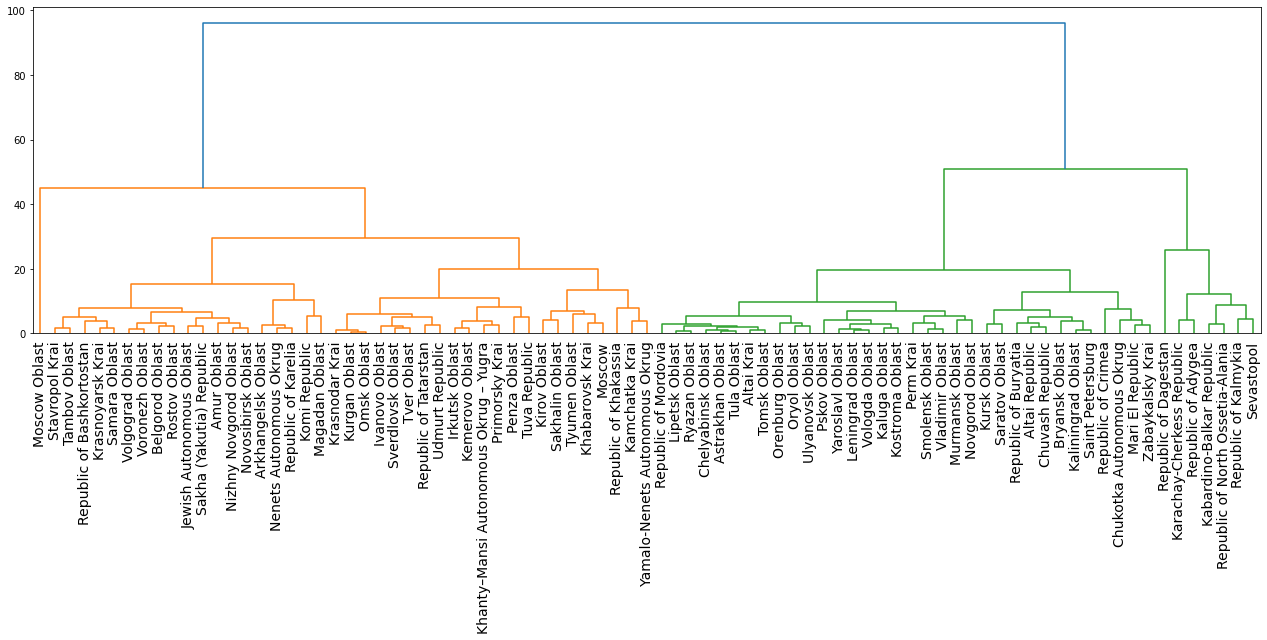

In [35]:
#Prepare the data for hierarchical clustering
data_features_recent = data_recent_group.iloc[:, 0:5].to_numpy()
data_index_recent = data_recent_group.index.to_numpy()

#Plot a dendrogram
plt.subplots(figsize=(22, 6))
hierarchy_recent = linkage(data_features_recent, method='complete')
dendrogram(hierarchy_recent, labels=data_index_recent, leaf_rotation=90, leaf_font_size=14)
plt.show()

In [36]:
#Split regions into 4 clusters.
recent_labels = fcluster(hierarchy_recent, 4, criterion='maxclust')
data_recent_hierarchy = data_recent_group.assign(hierarchy_cluster=recent_labels)
data_recent_hierarchy

,wine,beer,vodka,champagne,brandy,hierarchy_cluster
region,,,,,,
Altai Krai,4.43,45.20,4.83,0.87,0.30,3
Altai Republic,4.33,40.50,7.70,1.13,0.33,3
Amur Oblast,6.10,53.87,7.00,1.53,0.53,1
Arkhangelsk Oblast,9.37,55.03,12.27,1.87,0.93,1
Astrakhan Oblast,4.77,46.20,5.00,0.93,0.63,3
...,...,...,...,...,...,...
Vologda Oblast,9.03,45.23,10.10,1.17,0.60,3
Voronezh Oblast,5.60,52.80,4.43,1.43,0.57,1
Yamalo-Nenets Autonomous Okrug,4.70,81.57,9.00,1.87,1.37,1


In [37]:
#Search which cluster Saint Petersburg is in.
data_recent_hierarchy = data_recent_hierarchy.reset_index()
data_recent_hierarchy.columns.name = None
data_recent_hierarchy[data_recent_hierarchy['region'] == 'Saint Petersburg']

,region,wine,beer,vodka,champagne,brandy,hierarchy_cluster
59,Saint Petersburg,7.8,37.2,6.97,2.37,1.27,3


In [38]:
#Understand how many regions in cluster 3.
print(data_recent_hierarchy[data_recent_hierarchy['hierarchy_cluster'] == 3].shape)

(34, 7)


In [39]:
#Find the common regions as a priority in two different clustering results.
data_recent_list = data_recent_hierarchy.loc[data_recent_hierarchy['hierarchy_cluster'] == 3, 'region'].to_numpy()
top_10_list = data_top10['region'].to_numpy()

common_list=[]
not_in_list=[]
for z in top_10_list:
  if z in data_recent_list:
    common_list.append(z)
  else:
    not_in_list.append(z)
    
print('Top 10 Regions in both lists:', common_list)
print('Top 10 Regions not in the hierarchical cluster:', not_in_list)

Top 10 Regions in both lists: ['Leningrad Oblast', 'Chukotka Autonomous Okrug', 'Kaliningrad Oblast', 'Pskov Oblast', 'Saint Petersburg', 'Kursk Oblast']
Top 10 Regions not in the hierarchical cluster: ['Republic of Karelia', 'Kirov Oblast', 'Sverdlovsk Oblast', 'Penza Oblast']


# 5. Conclusion
This report aims to select 10 potential regions for the next wine promotions to maximize the profits. The chosen methods are K-means clustering and hierarchical clustering. Regarding K-means clustering, this report decided to proceed with K-means clustering with 4 clusters by the Elbow method. The K-means clustering with historical wine sales selects 17 regions with the same wine buying behavior as Saint Petersburg.

In order to figure out which 10 regions have the highest profitability. This report selects the regions by regression analysis. The higher the correlation coefficient, the higher the potential profit. Furthermore, by taking into account the wine sales, this report is able to pick the top 10 regions as below.

1. Republic of Karelia
2. Kirov Oblast
3. Leningrad Oblast
4. Sverdlovsk Oblast
5. Chukotka Autonomous Okrug
6. Kaliningrad Oblast
7. Pskov Oblast
8. Saint Petersburg
9. Kursk Oblast
10. Penza Oblast

As for the hierarchical clustering, this report uses a table with recent sales of all alcohol. After splitting the regions into 4 clusters, there are 34 regions picked by the sales combination. Since clustering by historical sales should more accurately reflect the buying behavior than clustering by only the recent sales, this report takes the top 10 regions clustered by K-means clustering with historical sales as a primary list.

By comparing the top 10 regions with the region list picked by the hierarchical clustering, this report is able to recommend that 6 regions should be the primary regions for the wine promotions.

1. Leningrad Oblast
2. Chukotka Autonomous Okrug
3. Kaliningrad Oblast
4. Pskov Oblast
5. Saint Petersburg
6. Kursk Oblast

Then, below 4 regions can be set as the lower priority in the top 10 regions.

1. Republic of Karelia
2. Kirov Oblast
3. Sverdlovsk Oblast
4. Penza Oblast

Since the budget is limited, it will be beneficial that this report suggests a priority list. This approach would help the operation team to plan risk management. Also, it will help the project manager create a better plan for setting up the priority of tasks.

According to the heatmap of the clusters selected by K-means, the 4 clusters have totally different buying trends. Clearly, the K-means clustering does split the regions properly. However, clustering by other methods will still be nice to have. Further analysis can try other methods and then compare different results to seek whether there is a better solution.

# 6. Reference
Brown, M. (2019). Innovation in Marketing - CIM Official Module Guide. Berkshire: The Chartered Institute of Marketing.

Chaffey, D. (2019). Digital Marketing: Strategy, Implementation and Practice (7th ed.). Harlow: Pearson Education.

Flood, B. (2018). K-means Clustering: Algorithm, Applications, Evaluation Methods, and Drawbacks. Towards Data Science. Retrieved from https://towardsdatascience.com/

Garbade, M. J. (2018). Understanding K-means Clustering in Machine Learning. Towards Data Science. Retrieved from https://towardsdatascience.com/
